In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../src')

from options_toolkit.bsm import bsm_call_price, bsm_put_price
from options_toolkit.monte_carlo import simulate_gbm_paths, monte_carlo_price, mc_delta, mc_vega
from options_toolkit.strategies import long_straddle_analysis, delta_hedge_illustration, vega_hedge_illustration
from options_toolkit.viz import plot_monte_carlo_histogram, plot_straddle_payoff, plot_delta_hedge_comparison

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')


✅ Monte Carlo & Strategies loaded! Interactive widgets ready.


## 1. Simulating GBM Paths

Geometric Brownian Motion (GBM) models stock prices as:
```
dS_t = r·S_t·dt + σ·S_t·dW_t
```

Let's simulate some price paths and visualize them.


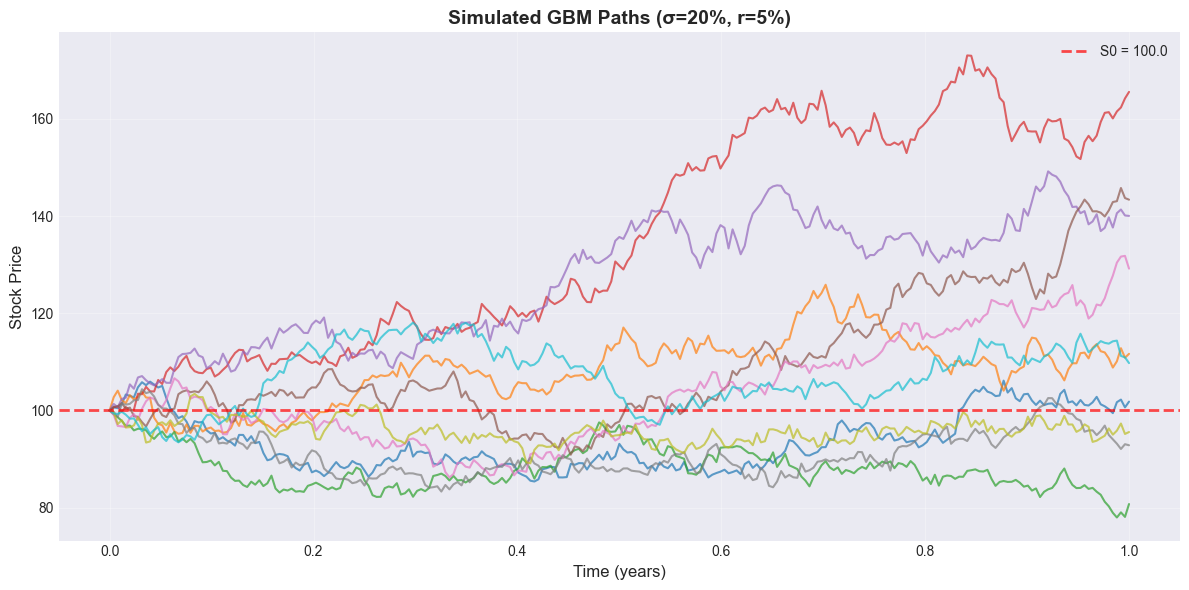

Initial price: $100.00
Terminal prices: $80.75 to $165.53
Average terminal price: $117.05


In [2]:
# Parameters
S0 = 100.0
r = 0.05
sigma = 0.20
T = 1.0
n_steps = 252  # Daily steps for 1 year
n_paths = 10

# Simulate paths
paths = simulate_gbm_paths(S0, r, sigma, T, n_steps, n_paths, seed=42)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
time_grid = np.linspace(0, T, n_steps + 1)

for i in range(n_paths):
    ax.plot(time_grid, paths[i, :], alpha=0.7, linewidth=1.5)

ax.axhline(y=S0, color='r', linestyle='--', linewidth=2, alpha=0.7, label=f'S0 = {S0}')
ax.set_xlabel('Time (years)', fontsize=12)
ax.set_ylabel('Stock Price', fontsize=12)
ax.set_title(f'Simulated GBM Paths (σ={sigma*100:.0f}%, r={r*100:.0f}%)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Initial price: ${S0:.2f}")
print(f"Terminal prices: ${paths[:, -1].min():.2f} to ${paths[:, -1].max():.2f}")
print(f"Average terminal price: ${paths[:, -1].mean():.2f}")


## 2. Monte Carlo Option Pricing

Now let's use Monte Carlo to price a call option and compare it with BSM.


In [ ]:
K = 100.0

# BSM price
bsm_price_call = bsm_call_price(S0, K, r, sigma, T)

# Monte Carlo price with different path counts
path_counts = [1000, 10000, 50000, 100000]

print(f"BSM Call Price: ${bsm_price_call:.4f}\n")
print(f"{'N Paths':<15} {'MC Price':<15} {'Error':<15} {'Error %':<15}")
print("-" * 60)

for n in path_counts:
    mc_price = monte_carlo_price(S0, K, r, sigma, T, n_steps=100, n_paths=n, 
                                 option_type="call", seed=42)
    error = mc_price - bsm_price_call
    error_pct = (error / bsm_price_call) * 100
    print(f"{n:<15} ${mc_price:<14.4f} ${error:<14.4f} {error_pct:<14.2f}%")

print("\nObservation: MC converges to BSM as n_paths increases!")


## 3. Visualizing MC Results

Let's create histograms of simulated terminal prices and payoffs.


In [4]:
# Simulate many paths for histogram
paths_for_hist = simulate_gbm_paths(S0, r, sigma, T, n_steps=100, n_paths=50000, seed=42)
terminal_prices = paths_for_hist[:, -1]

# MC price (discounted average payoff)
mc_price_call = monte_carlo_price(S0, K, r, sigma, T, n_steps=100, n_paths=50000, 
                                  option_type="call", seed=42)

# Plot
fig = plot_monte_carlo_histogram(terminal_prices, S0, K, option_type="call",
                                 bsm_price=bsm_price_call, mc_price=mc_price_call)
plt.show()

print(f"BSM Call Price: ${bsm_price_call:.4f}")
print(f"MC Call Price:  ${mc_price_call:.4f}")
print(f"Difference:     ${abs(mc_price_call - bsm_price_call):.4f}")


NameError: name 'K' is not defined

## 4. Long Straddle Strategy

A **long straddle** = long call + long put (same strike & expiration).

This strategy profits from **large moves in either direction** (volatility play).


In [ ]:
# Analyze long straddle
straddle = long_straddle_analysis(S0=100, K=100, r=0.05, sigma=0.25, T=0.5)

print("Long Straddle Analysis (K=100, T=6 months)")
print("=" * 60)
print(f"Call Price:     ${straddle['call_price']:.4f}")
print(f"Put Price:      ${straddle['put_price']:.4f}")
print(f"Total Cost:     ${straddle['total_cost']:.4f}")
print(f"\nBreakeven Points:")
print(f"  Lower: ${straddle['breakeven_lower']:.2f}")
print(f"  Upper: ${straddle['breakeven_upper']:.2f}")
print(f"\nNet Greeks:")
for greek, value in straddle['net_greeks'].items():
    print(f"  {greek.capitalize():8s}: {value:10.4f}")

print("\nInterpretation:")
print("- Delta ≈ 0: neutral to small price moves")
print("- Vega > 0: benefits from volatility increase")
print("- Theta < 0: loses value over time")
print("- Need stock to move beyond breakevens to profit!")


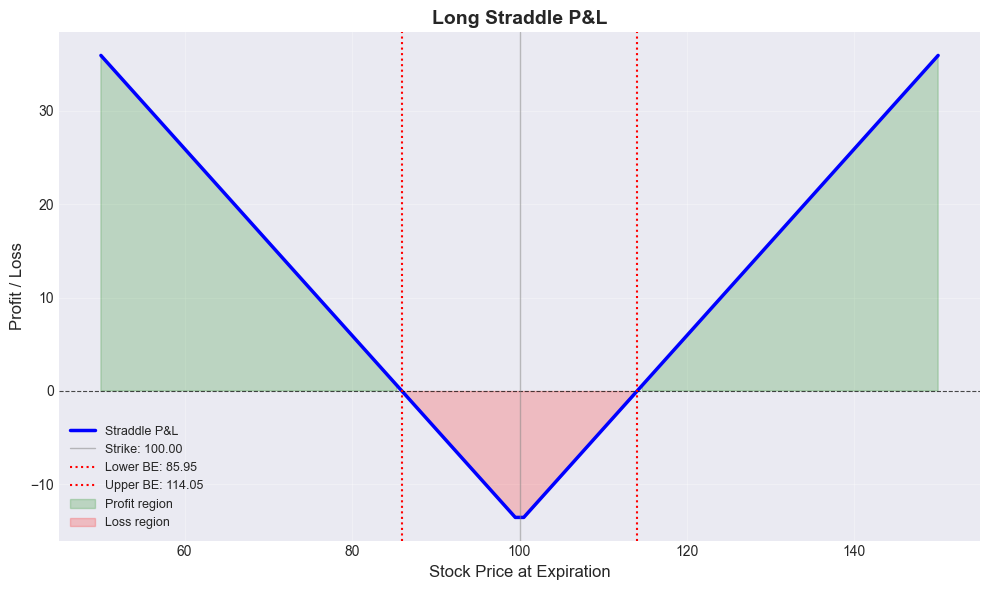

In [ ]:
# 🎛️ INTERACTIVE STRADDLE P&L VISUALIZER

@interact(
    K=FloatSlider(value=100, min=80, max=120, step=5, description='Strike ($):'),
    sigma=FloatSlider(value=0.25, min=0.10, max=0.60, step=0.05, description='Vol (σ):'),
    T=FloatSlider(value=0.5, min=0.25, max=2.0, step=0.25, description='Time (yrs):')
)
def plot_straddle_pnl(K=100, sigma=0.25, T=0.5):
    """Interactive straddle P&L plot."""
    straddle = long_straddle_analysis(S0=100, K=K, r=0.05, sigma=sigma, T=T)
    
    fig = plot_straddle_payoff(
        straddle['S_range'],
        straddle['pnl'],
        K=K,
        breakeven_lower=straddle['breakeven_lower'],
        breakeven_upper=straddle['breakeven_upper']
    )
    plt.show()
    
    print(f"V-shaped P&L: Profits from large moves, max loss at strike")


## 5. Delta Hedging Illustration

**Delta hedging**: neutralize price risk by offsetting delta with underlying shares.

For a long call with delta Δ, short Δ shares. This is a **static hedge** (one-time, not rebalanced).


Delta Hedge Illustration (ATM Call, T=1 year)
Call Price:      $12.3360
Call Delta:      0.6274
Hedge Ratio:     Short 0.6274 shares per call
Hedge Cost:      $62.74

This means: buy 1 call, short ~0.55 shares → delta-neutral at S0


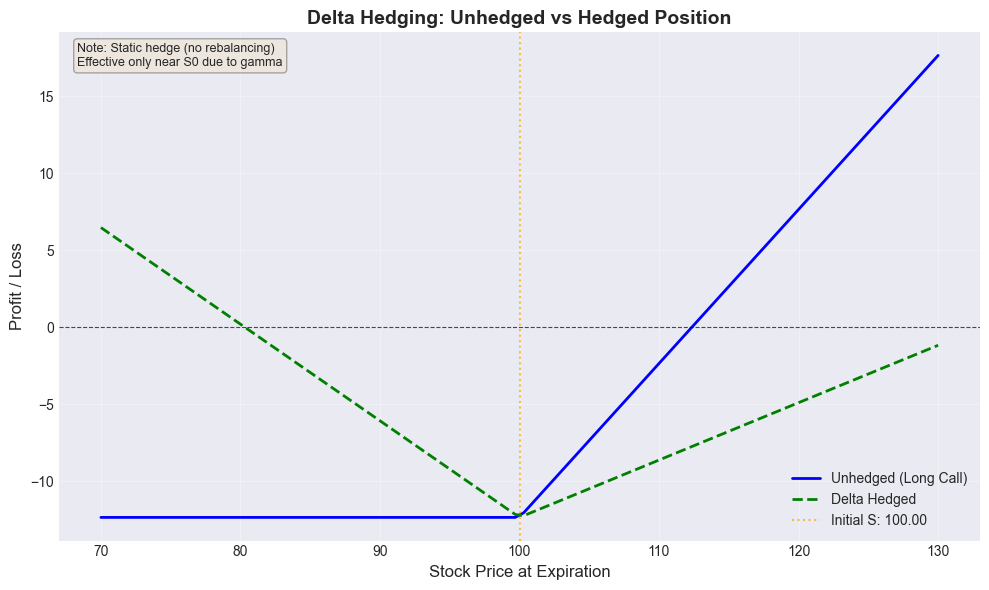


Observation:
- Hedged position is flatter near S0 (price risk reduced)
- But diverges away from S0 due to gamma (delta changes)
- In practice, traders rebalance frequently (dynamic hedging)


In [ ]:
# 🎛️ INTERACTIVE DELTA HEDGING

@interact(
    S0=FloatSlider(value=100, min=80, max=120, step=5, description='Stock ($):'),
    K=FloatSlider(value=100, min=80, max=120, step=5, description='Strike ($):'),
    sigma=FloatSlider(value=0.25, min=0.10, max=0.50, step=0.05, description='Vol (σ):'),
    T=FloatSlider(value=1.0, min=0.25, max=2.0, step=0.25, description='Time (yrs):')
)
def show_delta_hedge(S0=100, K=100, sigma=0.25, T=1.0):
    """Interactive delta hedge comparison."""
    hedge = delta_hedge_illustration(S0, K, 0.05, sigma, T)
    
    print("═" * 70)
    print(f"📊 DELTA HEDGING ILLUSTRATION (Static Hedge)")
    print("═" * 70)
    print(f"Call Price:        ${hedge['call_price']:.4f}")
    print(f"Call Delta:        {hedge['call_delta']:.4f}")
    print(f"Hedge Ratio:       Short {hedge['hedge_shares']:.4f} shares per call")
    print(f"Hedge Cost:        ${hedge['hedge_cost']:.2f}")
    print("═" * 70)
    print(f"Strategy: Buy 1 call + Short {hedge['hedge_shares']:.2f} shares")
    print(f"Effect: Neutralizes small price moves near ${S0}")
    print("═" * 70)
    
    fig = plot_delta_hedge_comparison(
        hedge['S_range'],
        hedge['pnl_unhedged'],
        hedge['pnl_hedged'],
        S0=S0
    )
    plt.show()
    
    print("\n⚠️  Static hedge only! Delta changes as stock moves (gamma effect)")
    print("💡 Real traders rebalance continuously = dynamic delta hedging")


## 6. Vega Hedging Illustration

**Vega hedging**: neutralize volatility risk by combining options with offsetting vegas.

Example: hold two calls with different strikes such that net vega ≈ 0.


In [8]:
# Vega hedge with two calls at different strikes
vega_hedge = vega_hedge_illustration(S0=100, K1=95, K2=105, r=0.05, sigma=0.25, T=1.0)

print("Vega Hedge Illustration (Two Calls: K1=95, K2=105)")
print("=" * 60)
print(f"\nCall 1 (K=95):")
print(f"  Price: ${vega_hedge['call1_price']:.4f}")
print(f"  Vega:  {vega_hedge['call1_greeks']['vega']:.4f}")

print(f"\nCall 2 (K=105):")
print(f"  Price: ${vega_hedge['call2_price']:.4f}")
print(f"  Vega:  {vega_hedge['call2_greeks']['vega']:.4f}")

print(f"\nPosition Sizes:")
print(f"  Call 1: {vega_hedge['position1']:.4f} (long)")
print(f"  Call 2: {vega_hedge['position2']:.4f} ({'short' if vega_hedge['position2'] < 0 else 'long'})")

print(f"\nNet Portfolio Greeks:")
for greek, value in vega_hedge['net_greeks'].items():
    print(f"  {greek.capitalize():8s}: {value:10.4f}")

print(f"\nTotal Cost: ${vega_hedge['total_cost']:.4f}")
print("\nInterpretation:")
print(f"- Net vega ≈ {vega_hedge['net_greeks']['vega']:.4f} (close to zero!)")
print("- Portfolio is hedged against volatility changes")
print("- But still exposed to other risks (delta, gamma, theta)")


Vega Hedge Illustration (Two Calls: K1=95, K2=105)

Call 1 (K=95):
  Price: $15.0471
  Vega:  0.3466

Call 2 (K=105):
  Price: $10.0022
  Vega:  0.3956

Position Sizes:
  Call 1: 1.0000 (long)
  Call 2: -0.8762 (short)

Net Portfolio Greeks:
  Delta   :     0.2186
  Gamma   :     0.0000
  Vega    :     0.0000
  Theta   :    -0.7790
  Rho     :     0.1558

Total Cost: $6.2827

Interpretation:
- Net vega ≈ 0.0000 (close to zero!)
- Portfolio is hedged against volatility changes
- But still exposed to other risks (delta, gamma, theta)
